# Language Identification


This Notebook is in the following sections:
1 Preamble - Libraries etc.
2 Data Exploration - a brief 'getting to know the data exploration
3 Set up of Functions and Models (i.e. code to be used when run
4 Running the code
5 Inference on some test files, including those created by me
My files are of me speaking in Spanish, French and German (5 of each for a more robust test than just 1


## 1 Infrastructure considerations and Libraries etc.

In [1]:
from google.colab import drive
!mkdir gdrive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
import os
#Symbolic link to get rid of annoying space in Google's 'My Drive'
!ln -s "/content/gdrive/My Drive/datasets/" /datadrive


In [0]:
os.listdir('/datadrive')

In [0]:
os.listdir('/datadrive/commonvoice')

In [0]:
# Change working directory for notebook
os.chdir('/datadrive/commonvoice' )

In [0]:
os.getcwd()

'/content/gdrive/My Drive/datasets/commonvoice'

In [0]:
import os
os.listdir(os.getcwd())

In [0]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os
import pickle

## 2 Explore and look at the data and metadata

In [0]:

df = pd.read_csv('cv3000.csv')

In [6]:
df.head()

client_id  ... category
0  4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
1  4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
2  4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
3  4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
4  4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en

[5 rows x 10 columns]

In [0]:
# Metadata has been set up with train and test folds flagged
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [8]:
print(len(train))
print(len(valid))

12000
4000


In [0]:
#Test
#train = df.head(10)
#valid = df.tail(10)
os.getcwd()

'/content/gdrive/My Drive/datasets/commonvoice'

In [0]:
wav, sr = librosa.load('/datadrive/commonvoice/en/common_voice_en_20237101.mp3', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

## 3 Functions and classes

In [0]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [0]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [0]:
#Using VARY OPEN for unpickling - Uses Excel - Version in next cell preferred but both do the job
# As above but a bit more flexible

class VoiceData(Dataset):
  def __init__(self, base, df, in_col, out_col,fold): #self, file
    x=[]
    self.df = df
    #print('1',base,'2',df,'3',in_col,'4',out_col)
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    if fold == 'train':
      filename='train3000.pickle'
    else:
      filename='valid1000.pickle'  

    with open(filename, 'rb') as f:
      t_data = pickle.load(f)  
      for ind in tqdm(range(len(df))):
        #print('Df:',len(df))
        row = df.iloc[ind]
        file_path = os.path.join(base,row[in_col])

        #self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
        #print(ind)
        self.data.append(t_data[0][ind])

        self.labels.append(self.c2i[row['category']])
#############For pickling one-off
    #   x.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
    # filename = 'train.pickle'
    # with open(filename, 'wb+') as f:
    #   pickle.dump([x], f)
###################

  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [0]:
# Get environment
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


## 4 Running the code
Load Training Data
Load Validation Data
Run Model

In [12]:

#train_data = VoiceData('audio', train, 'filename', 'category')
#train_data = VoiceData('Voice/audio', train, 'filename', 'category','train')

#Multilabel - for later development and comparison if time (which there probably won't be)

#train_data = VoiceData('/datadrive/commonvoice', train, 'path', 'category','gender', 'age', 'accent','client_id','train')

train_data = VoiceData('/datadrive/commonvoice', train, 'path', 'category','train')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [13]:
# Check pickle file content
filename = 'train3000.pickle'
with open(filename, 'rb') as f:
  y = pickle.load(f)
#print(os.getcwd())
print(len(y[0]))
print(y[0][0][0])


12000
[[  0  13  23 ...  63  62 126]
 [  0  21  32 ... 110 120 144]
 [ 25  36  23 ... 118 129 150]
 ...
 [ 14  18  13 ...  34  32  16]
 [ 18  26  20 ...  31  38  33]
 [ 20  16  15 ...  22  30  31]]


In [14]:
# Load Validation Data

#valid_data = VoiceData('audio', valid, 'filename', 'category')
#valid_data = VoiceData('/datadrive/commonvoice', valid, 'path', 'category','gender', 'age', 'accent', 'client_id','valid')
valid_data = VoiceData('/datadrive/commonvoice', valid, 'path', 'category','valid')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
# Data loaded in language batches so needs shuffling (though training and test 
# folds are mixed, so probably not too much of a problem, but no harm if we do it anyway in
# - data sets might change)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [15]:
# Hope that cuda is available or this isn't going to work

if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
print(device)

cpu


In [0]:
#model = VoiceModel(input_shape=(1,128,431), batch_size=16, num_cats=50).to(device)

In [0]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [0]:
# Loss function values (remember to set model first)
# Previous version

# loss_fn = nn.CrossEntropyLoss()
# learning_rate = 2e-5
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# epochs = 60
# train_losses = []
# valid_losses = []

In [0]:
#The training side of things

def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [0]:
# In two minds about this - can force learning rate decay if noo progress noted
# Saw it in a few online networks and it looked like a good function to have in reserve
# though added output of old and new to check which way it is being pushed

def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

#Error - 
#RuntimeError: size mismatch, m1: [16 x 110592], m2: [217088 x 500] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

#train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

In [0]:
# Debug
#print(train_loader.dataset.data[0].shape)

(1, 128, 216)


In [19]:
# Selection of initial models
# Some good ones supplied
# Can use pretrained or not
# Will replace if time with actual layers as I'd like to pop them and look at filters

from torchvision.models import resnet34, resnet152, resnet18, resnet101, resnet50
#resnet_model = resnet18(pretrained=True)
#resnet_model = resnet18(pretrained=True)
resnet_model = resnet34(pretrained=True)
#resnet_model = resnet18(pretrained=True, num_classes=3)
#resnet_model = resnet18(pretrained=False)
#resnet_model = resnet50(pretrained=True)
num_classes=4
#resnet_model.fc = nn.Linear(512,50)
resnet_model.fc = nn.Linear(512,num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 10
train_losses = []
valid_losses = []

In [0]:
print(optimizer)
#print(batch_size)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 2e-05
    weight_decay: 0
)


In [0]:
################################################################################
# Process below was killed - it was just as a sanity check of the code before submitting
# Done on a CPU - code checked out ok but it can't run to completion on a CPU.
###############################################################################

In [24]:
# Leave out - done later

#learning_rate = 2e-4
learning_rate = 1e-2
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 10  #50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    old_lr = learning_rate
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate from', old_lr, 'to', new_lr)
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: ignored

In [0]:
print(train)

                                               client_id  ... category
0      4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
1      4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
2      4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
3      4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
4      4f29be8fe932d773576dd3df5e111929f4e22242232245...  ...       en
...                                                  ...  ...      ...
14995  d88f27eb22ad7592d067a45bf3e3009308bf652b135125...  ...       es
14996  db5ab718f7a65a016bd694e0bc5aca4f505e53b78b795f...  ...       es
14997  db5ab718f7a65a016bd694e0bc5aca4f505e53b78b795f...  ...       es
14998  db5ab718f7a65a016bd694e0bc5aca4f505e53b78b795f...  ...       es
14999  db5ab718f7a65a016bd694e0bc5aca4f505e53b78b795f...  ...       es

[12000 rows x 10 columns]


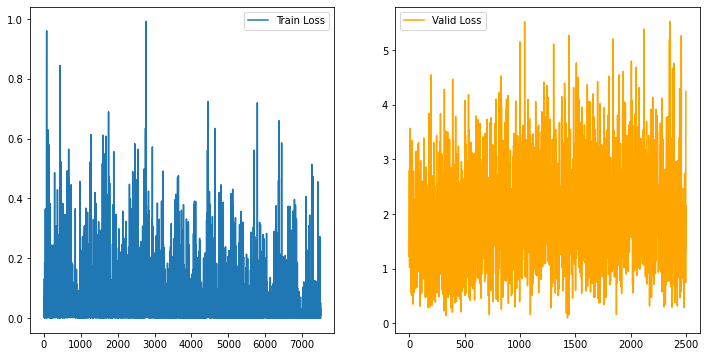

In [0]:
#Charts output
#Note the ones displayed here are NOT actual ones - just run through to check code before submitting
# **************** Please see report for aactual output ***********

tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


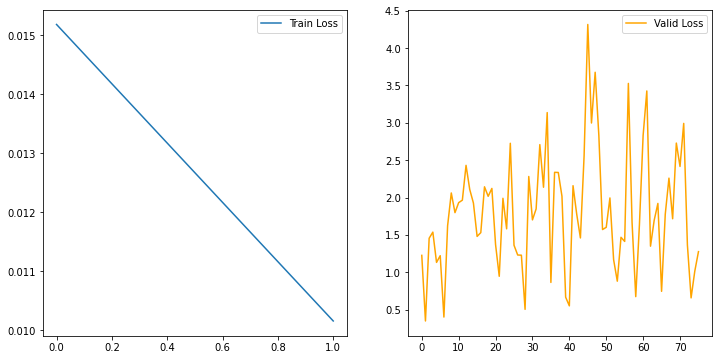

In [0]:
# Above charts are for iteration output
# Showing smother epoch versions

# Again **** Please see report for actual charts - these were just for the code sanity check
# before submitting

#print(len(vl))
#print(len(tl))
#print(vl)

tl_epoch = tl[0::4568]
vl_epoch = vl[0::33]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl_epoch)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl_epoch,'orange')
plt.legend(['Valid Loss'])

In [0]:
with open('langesc34Trueresnet3000-10e.pth','wb') as f:
  torch.save(resnet_model, f)

In [0]:
import pickle
with open('langindtocat34True3000-10e.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

In [0]:
os.getcwd()

'/content/gdrive/My Drive/datasets/commonvoice'

# 5 Inference on Own Files and some others

The 'real' test - does this generalise to other data
The lesson is that this kind of data and feature extraction needs more data (as ever) and
probably quite a lot of compute time. 
This was listed as an MSc final project task - and it would probably be a good one to extend with much
more time to run the models - the literature says that it is possible.

My own files were produced in different formats, to match the training data formats.
This was so that the file format would not be a distracting feature


In [0]:
os.getcwd()
os.chdir('saved_models')

In [0]:
os.listdir()

['resnet18_untrained_langesc50resnet.pth',
 'resnet18_untrained_langindtocat.pkl',
 'langindtocat(Res34_KagFull 20 epochs).pkl',
 'langesc34resnet(Res34_KagFull 20 epochs).pth',
 'langindtocat (Res18_KagFull 20 epochs).pkl',
 'langesc18resnet (Res18_KagFull 20 epochs).pth',
 'langesc18Trueresnet3000.pth',
 'langindtocat18True3000.pkl',
 'langesc34Trueresnet3000-20e.pth',
 'langindtocat34True3000-20e.pkl']

In [0]:
import IPython
with open('langindtocat34True3000-20e.pkl','rb') as f:
  indtocat = pickle.load(f)

In [0]:


owndir='/datadrive/ownfiles/mp3/'
ownfile='Tom_English_1.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 17.51835823059082
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4230,  0.0996,  0.0303, -0.4691]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_English_2.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 17.409626007080078
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4606,  0.0989,  0.0323, -0.4694]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_English_3.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 27.751203536987305
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.3471,  0.1842, -0.0103, -0.4796]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_English_4.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 22.112966537475586
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4582,  0.1454, -0.0254, -0.5121]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_English_5.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 26.0745849609375
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4174,  0.1472, -0.0467, -0.4114]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_Spanish_1.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 27.143579483032227
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.5183,  0.1931, -0.0433, -0.4805]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_Spanish_2.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 19.813705444335938
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.5086,  0.1257,  0.0302, -0.5068]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_Spanish_3.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 21.281368255615234
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4885,  0.1321,  0.0771, -0.4772]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_Spanish_4.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 21.19572639465332
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.5256,  0.1414, -0.0536, -0.4453]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_Spanish_5.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 25.399169921875
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4354,  0.1602,  0.0071, -0.4704]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_1.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 24.730478286743164
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4314,  0.1458, -0.0363, -0.4436]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_2.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 22.468324661254883
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4336,  0.1286,  0.0609, -0.4439]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_3.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 15.590691566467285
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4729,  0.0874,  0.0030, -0.4726]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_4.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 26.310447692871094
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.5362,  0.1914, -0.0622, -0.3914]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_5.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 15.357965469360352
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4500,  0.0863,  0.0208, -0.4758]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_German_1.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 19.019014358520508
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4834,  0.1135, -0.0295, -0.4298]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_2.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 22.468324661254883
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4336,  0.1286,  0.0609, -0.4439]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_3.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 15.590691566467285
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4729,  0.0874,  0.0030, -0.4726]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_4.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 26.310447692871094
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.5362,  0.1914, -0.0622, -0.3914]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_French_5.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 15.357965469360352
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4500,  0.0863,  0.0208, -0.4758]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_German_1.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 19.019014358520508
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4834,  0.1135, -0.0295, -0.4298]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_German_2.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 27.99726104736328
Least likely: de
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4567,  0.1776, -0.0264, -0.4555]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_German_3.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 18.178237915039062
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4489,  0.1100,  0.0329, -0.4951]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_German_4.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 22.118528366088867
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4778,  0.1470, -0.0162, -0.5175]], grad_fn=<AddmmBackward>)


In [0]:
ownfile='Tom_German_5.mp3'
filename = owndir + ownfile
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]


#print(ind)
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
#print(conf.item())
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 26.73698616027832
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4209,  0.1729, -0.0897, -0.4738]], grad_fn=<AddmmBackward>)


In [0]:
#!wget 'http://soundbible.com/grab.php?id=2215&type=wav' -O "dog.wav"
#filename='dog.wav'
filename='/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/de_m_fc6bd6bb9d66a89bb8d8a8a7efa23e6b.fragment21.noise11.flac'
#WORSE
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 18.472122192382812
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4790,  0.1094, -0.0264, -0.4827]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/en_f_c8835fb3edef243176e1e9beef1f9681.fragment10.speed2.flac'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  es Confidence: 55.6136360168457
Least likely: en
{0: 'de', 1: 'en', 2: 'es'}
tensor([[ 2.4849, -2.9651,  3.7151,  3.0546]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/en_f_058b70233667e1b64506dddf9f9d6b46.fragment3.noise4.flac'
#BETTER
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  es Confidence: 56.073062896728516
Least likely: en
{0: 'de', 1: 'en', 2: 'es'}
tensor([[ 2.3974, -2.6369,  3.3661,  2.5762]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/en_f_058b70233667e1b64506dddf9f9d6b46.fragment3.noise4.flac'
#BETTER
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 31.675321578979492
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.3871,  0.1801, -0.0407, -0.3885]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/common_voice_en_1.mp3'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  es Confidence: 56.55063247680664
Least likely: en
{0: 'de', 1: 'en', 2: 'es'}
tensor([[ 1.9447, -2.1053,  2.7401,  2.0547]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/common_voice_en_100050.mp3'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  es Confidence: 56.34409713745117
Least likely: en
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[ 1.9519, -2.1097,  2.7229,  2.0632]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/emanuel_extrana.mp3'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  es Confidence: 56.25560760498047
Least likely: en
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[ 2.0704, -2.2684,  2.9171,  2.2348]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/emanuel_extrana.mp3'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  en Confidence: 26.427549362182617
Least likely: fr
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[-0.4230,  0.1680,  0.0183, -0.4677]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
#####Changes with untrained
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/the_great_gatsby_favourite_book.mp3'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

Most Likely:  es Confidence: 55.99818801879883
Least likely: en
{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
tensor([[ 2.1565, -2.4919,  3.1712,  2.5298]], grad_fn=<AddmmBackward>)


In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/francette1_arribada_africa.mp3'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/aurelia_FrCatalan.mp3'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
print(indtocat)
print(pr)
IPython.display.display(IPython.display.Audio(filename=filename))

In [0]:
#!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
#filename='cat.wav'
filename = '/content/gdrive/My Drive/datasets/datasets/master/POCData/POCData/Test files/ricard5_historia_familiaSpCatalan.mp3'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
last = pr.argmin(dim=1).cpu().detach().numpy().ravel()[0]
conf = (pr[0][ind]/(pr[0][ind]-pr[0][last])*100)
print('Most Likely: ',indtocat[ind], 'Confidence:', conf.item())
print('Least likely:',indtocat[last])
IPython.display.display(IPython.display.Audio(filename=filename))

In [0]:
print(indtocat)

{0: 'de', 1: 'en', 2: 'es', 3: 'fr'}
